seq2seq의 단점을 개선하면서도 인코더-디코더 구조를 유지하는 트랜스포머 모델을 통해 챗봇 구현

## 1) 트랜스포머
* 2017년 구글의 "Attention is all you need" 논문에 나온 모델
* seq2seq 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션만으로 구현한 모델
  * RNN을 사용하지 않고 인코더-디코더 구조를 설계하였음에도 성능도 RNN보다 우수하다는 특징

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### 1. 기존 seq2seq 모델의 한계
* 인코더가 입력 시퀀스를 **하나의 벡터로 압축**하는 과정에서 **입력 시퀀스의 정보가 일부 손실**된다는 단점. 이를 보정하기 위해서 어텐션 사용
* 그런데 어텐션을 RNN의 보정을 위한 용도가 아니라, **아예 어텐션으로 인코더와 디코더 만들기**

### 2. 트랜스포머의 주요 하이퍼파라미터
* **d model** : 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기 의미. 임베딩 벡터의 차원 또한 d model이며, 각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때도 이 차원 유지. 
* **num_layers** : 트랜스포머에서 하나의 인코더와 디코더를 층으로 생각하였을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미. 논문에서는 각각 총 6개씩 싸음
* **num_heads** : 트랜스포머에서는 어텐션을 사용할 때, 1번 하는 것보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식 선택. 이때 이 병렬의 개수 의미.
* **d ff**: 트랜스포머 내부에는 피드 포워드 신경망이 존재. 이때 은닉층의 크기 의미. 피드 포워드 신경망의 입력층과 출력층의 크기는 d model

### 3. 트랜스포머
* RNN 사용하지 않지만 기존의 seq2seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조 유지
* 다른 점은 인코더와 디코더라는 단위가 **N개 존재**할 수 있다는 점
* 이전 seq2seq 구조에서는 인코더와 디코더에서 각각 하나의 RNN이 t개의 시점(time-step)을 가지는 구조였다면, 이번에는 인코더와 디코더라는 단위가 N개로 구성되는 구조. 트랜스포머를 제안한 논문에서는 인코더와 디코더의 개수를 각각 6개 사용
* 트랜스포머의 인코더와 디코더는 단순히 각 단어의 임베딩 벡터들을 입력받는 것이 아니라 임베딩 벡터에서 조정된 값을 입력받는데 이에 대해서 알아보기 위해 입력 부분 확대

### 4. 포지셔널 인코딩
* 트랜스포머의 내부를 이해하기 전에 우선 트랜스포머의 입력에 대해서 알아봄
* RNN이 자연어처리에서 유용했던 이유는 **단어의 위치에 따라 단어를 순차적으로 입력**받아서 처리하는 RNN의 특성으로 인해 각 단어의 **위치 정보(positional information)**를 가질 수 있다는 점

* **하지만** 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있음
  * 트랜스포머는 단어의 위치 정보를 얻기 위해서 **각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용**. 이를 **포지셔녈 인코딩(positional encoding)**이라고 함
    * 임베딩 벡터가 인코더의 입력으로 사용되기 전에 인코딩 값이 더해지는 과정
    * 트랜스포머는 **사인 함수와 코사인 함수의 값**을 임베딩 벡터에 더해주므로서 단어의 순서 정보를 더하여 줌
    * 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 '문장 벡터 행렬'과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어짐
      * pos: 입력 문장에서의 임베딩 벡터의 위치
      * i: 임베딩 벡터 내의 차원의 인덱스 의미
        * 임베딩 벡터 내의 각 차원의 인덱스가 짝수면 사인 함수의 값, 홀수면 코사인 함수의 값
      * d model: 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터. 앞으로 보게 될 트랜스포머의 각종 구조에서 d model의 값이 계속해서 등장하는 이유. 임베딩 벡터 또한 d model의 차원을 가짐.
  * 임베딩 벡터에 포지셔널 인코딩값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라짐. 결국 트랜스포머의 입력은 순서 정보가 고려된 임베딩 벡터.

In [54]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


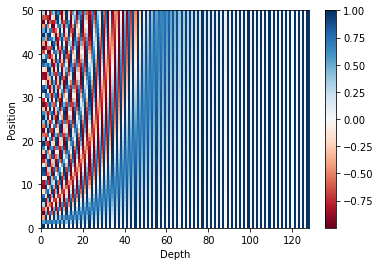

In [55]:
# 50 x 128의 크기를 가지는 포지셔널 인코딩 행렬을 시각화하여 어떤 형태를 가지는지 확인
# 입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬

# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 5. Attention
* 셀프 어텐션은 인코더에서 이루어짐. 본질적으로 Query, Key, Value가 동일한 경우.
* 인코더-디코더 어텐션에서는 Query가 디코더의 벡터인 반면, Key와 Value가 인코더의 벡터이므로 셀프 어텐션이라고 부르지 않음
  * Query, Key 등이 같다는 것은 벡터의 값이 같다는 것이 아니라 벡터의 출처가 같다는 의미
    - 인코더의 셀프 어텐션: Query = Key = Value
    - 디코더의 마스크드 셀프 어텐션: Query = Key = Value
    - 디코더의 인코더-디코더 어텐션: Query : 디코더 벡터 / Key = Value  : 인코더 벡터

### 6. Enoder
* 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓음
* 논문에서는 총 6개의 인코더 층을 사용
* 하나의 인코더 층은 총 2개의 서브층(sublayer)로 나뉘어짐: **셀프 어텐션과 피드 포워드 신경망**
* 멀티 헤드 셀프 어텐션: 셀프 어텐션을 병렬적으로 사용
* 포지션 와이즈 피드 포워드 신경망: 우리가 알고있는 일반적인 피드 포워드 신경망

### 7. 인코더의 셀프 어텐션
#### 1) 셀프 어텐션의 의미와 이점
* 어텐션 함수는 주어진 Query에 대해서 모든 Key와의 유사도를 각각 구함. 그리고 구해낸 이 유사도를 가중치로 하여 키와 맵핑되어 있는 각각의 Value에 반영. 그리고 유사도가 반영된 Value를 모두 가중합하여 리턴.
* 셀프 어텐션은 어텐션을 자기 자신에게 수행한다는 의미. 앞서 배운 seq2seq에서 어텐션을 사용할 경우의 Q, K, V의 정의 다시 생각
  * Q = Query : t 시점의 디코더 셀에서의 은닉 상태
  * K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
  * V = Values : 모든 시점의 인코더 셀의 은닉 상태들
* 그런데 사실 t 시점이라는 것은 계속 변화하면서 반복적으로 쿼리를 수행하므로 결국 전체 시점에 대해서 일반화 가능
  * Q = Querys : 모든 시점의 디코더 셀에서의 은닉 상태들
  * K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
  * V = Values : 모든 시점의 인코더 셀의 은닉 상태들
* 기존에는 디코더 셀의 은닉 상태가 Q이고 인코더 셀의 은닉 상태가 K라는 점에서 Q와 K가 서로 다른 값을 가지고 있었음. 그런데 셀프 어텐션에서는 Q, K, V가 전부 동일.
  * Q, K, V : 입력 문장의 모든 단어 벡터들

#### 2) Q, K, V 벡터 얻기

#### 3) Scaled dot-product Attention
* Q, K, V 벡터를 얻었다면 지금부터는 기존에 배운 어텐션 메커니즘과 동일. 각 Q 벡터는 모든 K 벡터에 대해서 어텐션 스코어를 구하고, 어텐션 분포를 구한 뒤에 이를 사용하여 모든 V 벡터를 가중합하여 어텐션 값 또는 컨텍스트 벡터를 구하게 됨. 그리고 이를 모든 Q 벡터에 대해서 반복
* 트랜스포머에서는 어텐션 챕터에서 사용했던 내적만을 사용하는 어텐션 함수가 아니라 여기에 특정값으로 나눠준 어텐션 함수(아래)를 사용. 이러한 함수를 스케일드 닷-프로덕트 어텐션이라고 함
  > score(q, k) = q·k/root(n)
* ... 어텐션 스코어에 소프트맥스 함수를 사용하여 어텐션 분포(Attention Distribution)을 구하고, 각 V벡터와 가중합하여 어텐션 값(Attention Value)를 구함. 이를 단어 I에 대한 어텐션 값 또는 단어 I에 대한 컨텍스트 벡터(context vector)라고도 부름

#### 4) 행렬 연산으로 일괄 처리하기
* 사실 각 단어에 대한 Q, K, V 벡터를 구하고 스케일드 닷-프로덕트 어텐션을 수행하였던 위의 과정들은 벡터 연산이 아니라 행렬 연산을 사용하면 일괄 계산이 가능. 지금까지 벡터 연산으로 설명하였던 이유는 이해를 돕기 위한 과정이고, 실제로는 행렬 연산으로 구현됨
  * 각 단어 벡터마다 일일히 가중치 행렬을 곱하는 것이 아니라 **문장 행렬**에 가중치 행렬을 곱하여 Q 행렬, K 행렬, V 행렬을 구함
  * 이렇게 어텐션 스코어 행렬 구했으면 남은 것은 어텐션 분포를 구하고, 이를 사용하여 모든 단어에 대한 어텐션 값을 구하는 일
  * 이는 간단하게 어텐션 스코어 행렬에 소프트맥스 함수를 사용하고, V 행렬을 곱하는 것으로 해결

#### 5) 스케일드 닷-프로덕트 어텐션 구현하기

In [56]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

* Q 행렬과 K 행렬을 전치한 행렬 곱하기
* 소프트맥스 함수를 사용하여 어텐션 분포 행렬을 얻은 뒤에 V 행렬과 곱함
* 코드에서 mask가 사용되는 if문은 아직 배우지 않은 내용으로 지금은 무시하고 넘어감


In [57]:
# scaled_dot_product_attention 함수가 정상 작동하는지 테스트
# 우선 temp_q, temp_k, temp_v라는 임의의 Query, Key, Value 행렬을 만들고
# 이를 scaled_dot_product_attention 함수에 입력으로 넣어 함수가 리턴하는 값을 출력

# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
                      
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

In [58]:
# 여기서 주목할 점은 Query에 해당하는 temp_q의 값 [0, 10, 0]은 
# Key에 해당하는 temp_K의 두번째 값 [0, 10, 0]과 일치한다는 점
# 어텐션 분포와 어텐션 값은 과연 어떤 값이 나올까

# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [59]:
# Query의 값은 Key의 세번째 갑소가 네번째 값 두 개의 값과 모두 유사하다는 의미에서
# 어텐션 분포는 [0, 0, 0.5, 0.5]의 값을 가짐
# 결과적으로 나오는 값 [550, 5.5]는 Value의 세번째 값 [100,5]에 0.5를 곱한 값과
# [1000,6]dp 0.5를 곱한 값의 원소별 합
# 이번에는 하나가 아닌 3개의 Query의 값을 함수의 입력으로 사용

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) #어텐션 ㄱ밧

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


#### 6) Multi-head Attention
* 앞서 배운 어텐션에서는 d model의 차원을 가진 단어 벡터를 num_heads로 나눈 차원을 가지는 Q, K, V 벡터로 바꾸고 어텐션을 수행. 
* 논문 기준으로는 512의 차원이 각 단어 벡터를 8로 나누어 64차원의 Q, K, V 벡터로 바꾸어서 어텐션을 수행한 셈인데, 이제 num_heads의 의미와 왜 d model의 차원을 가진 단어 벡터를 가지고 어텐션을 하지 않고 차원을 축소시킨 벡터로 어텐션을 수행하였는지 이해해보기
* 트랜스포머 연구진은 한 번의 어텐션을 하는 것보다 여러 번의 어텐션을 병렬로 사용하는 것이 더 효과적이라고 판단. 그래서 d model의 차원을 num_heads개로 나누어 d model / num_heads의 차원을 가지는 Q, K, V에 대해서 num_heads 개의 병렬 어텐션 수행. 논문에서는 8.
  * 이때 각각의 어텐션 값 행렬을 어텐션 헤드라고 부름. 이때 가중치 행렬 W Q, W K, W V의 값은 8개의 어텐션 헤드마다 전부 다름
#### Q. 병렬 어텐션으로 얻을 수 있는 효과?
  * 머리가 여러 개이기 때문에 여러 시점에서 상대방을 볼 수 있음
  * 어텐션을 병렬로 수행하여 다른 시각으로 정보들을 수집


* 병렬 어텐션을 모두 수행하였다면 모든 어텐션 헤드를 연결(concatenate)함  
* 트랜스포머는 다수의 인코더를 쌓은 형태인데 인코더에서의 입력의 크기가 출력에서도 동일 크기로 계속 유지되어야만 다음 인코더에서도 다시 입력이 될 수 있기 때문

#### 7) 멀티 헤드 어텐션 구현하기
* 크게 두 종류의 가중치 행렬
1. Q, K, V 행렬을 만들기 위한 가중치 행렬인 **WQ, WK, WV 행렬**
2. 바로 어텐션 헤드들을 연결(concatenate) 후에 곱해주는 **WO 행렬**
  * 가중치 행렬을 곱하는 것을 구현 상에서는 입력을 밀집층(Dense layer)를 지나게 하므로서 구현
  * 케라스 코드 상으로 지금까지 줄기차게 사용해왔던 Dense()에 해당
  > Dense(units)

* 크게 다섯 가지 파트로 구성
1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)를 지나게 함
2. 지정된 헤드 수(num_heads)만큼 나눈다(split)
3. 스케일드 닷 프로덕트 어텐션
4. 나눠졌던 헤드들을 연결(concatenate)한다
5. WO에 해당하는 밀집층을 지나게 한다



In [60]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

#### 8) 패딩 마스크 Padding mask
* scaled dot product attention 함수 내부를 보면 mask라는 값을 인자로 받아서, 이 mask값에다가 -1e9라는 아주 작은 음수값을 곱한 후 어텐션 스코어 행렬을 더해줌. 이 연산의 정체는?

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  중략..
  logits += (mask * -1e9) # 어텐션 스코어 행렬인 logits에 mask*-1e9 값을 더해주고 있다
  중략..

* 이는 입력 문장에 <PAD> 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산. 
* <PAD>는 실질적인 의미를 가진 단어가 아니라서 트랜스포머에서는 Key의 경우에 <PAD> 토큰이 존재한다면 이에 대해서는 유사도를 구하지 않도록 마스킹(Masking)을 해주기로 함
  * 마스킹: 어텐션에서 제외하기 위해 값을 가린다는 의미
* 어텐션 스코어 행렬에서 행에 해당하는 문장은 Query, 열에 해다아는 문장은 Key
  * Key에 <PAD>가 있는 경우에는 해당 열 전체를 마스킹
  * How? 어텐션 스코어 행렬의 마스킹 위치에 **매우 작은 음수값**을 넣어주는 것
* 현재 어텐션 스코어 함수는 소프트맥스 함수를 지나지 않은 상태.
  * 어텐션 스코어 함수는 소프트맥스 함수를 지나고, 그 후 value 행렬과 곱해지게 됨
  * 그런데 현대 마스킹 위치에 매우 작은 음수 값이 들어가 있으므로 어텐션 스코어 행렬이 소프트맥스 함수를 지난 후에는 해당 위치의 값은 0에 굉장히 가까운 값이 되어 단어 간 유사도를 구하는 일에 <PAD> 토큰이 반영되지 않게 됨
* 패딩 마스크 구현 방법: 입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것

In [61]:
# 정수 시퀀스에서 0인 경우에는 1로 변환, 그렇지 않은 경우에는 0으로 변환

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[: , tf.newaxis, tf.newaxis, :]

In [62]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


* 위 벡터를 통해서 1의 값을 가진 위치의 열을 어텐션 스코어 행렬에서 마스킹하는 용도로 사용할 수 있음
* 위 벡터를 스케일드 닷 프로덕트 어텐션의 인자로 전달하면, 스케일드 닷 프로덕트 어텐션에서는 위 벡터에다가 매우 작은 음수값인 -1e9를 곱하고, 이를 행렬에 더해주어 해당 열을 전부 마스킹하게 되는 것
* 첫번째 서브층인 멀티 헤드 어텐션을 구현함. 앞서 인코더는 두 개의 서브 서브층(subplayer)로 나뉘어진다고 언급한 적이 있는데, 이제 두번째 서브층인 **포지션-와이드 피드 포워드 신경망**에 대해서 알아봄

### 8. 포지션-와이즈 피드 포워드 신경망(Position-wise FFNN)
* FFNN은 사실 인코더와 디코더에서 공통적으로 가지고 있는 서브층. 쉽게 말하면 완전 연결 FFNN.
  > FFNN(x) = MAX(0, xW1 + b1)W2 + b2
  

In [71]:
# 다음의 코드는 인코더와 디코더 내부에서 사용할 예정입니다.
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outputs = tf.keras.layers.Dense(units=d_model)(outputs)

NameError: ignored

### 9. 잔차 연결과 층 정규화
* 두 개의 서브층을 가진 인코더에 추가적으로 사용하는 기법이 바로 Add and Norm
  * Residual connection and layer normalization
#### 1) 잔차 연결(Residual connection)
* F(x) : 트랜스포머에서는 서브층에 해당
  * 잔차 연결은 서브층의 입력과 출력을 더하는 것
  * 트래스포머의 서브층의 입력과 출력은 동일한 차원을 갖고 있으므로, 서브층의 입력과 서브층의 출력은 덧셈 연산을 할 수 있음. 이것이 바로 인코더 그림에서 각 화살표가 서브층이 입력에서 출력으로 향하도록 그려졌던 이유
  * 잔차 연결은 컴퓨터 비전 분야에서 주로 사용되는 모델의 학습을 돕는 기법
> x + Subplayer(x)
  * 가령, 서브층이 멀티 헤드 어텐션이었다면 잔차 연결 연산은 다음과 같음
  > H(x) = x + Multi - head Attention(x)
#### 2) 층 정규화(Layer Normalization)
* 잔차 연결을 거친 결과는 이어서 층 정규화 과정을 거치게 됨. 잔차 연결의 입력을 x, 잔차 연결과 층 정규화 두 가지 연산을 모두 수행한 후의 결과 행렬을 LN
* 잔차 연결 후 층 정규화 연산을 수식으로 표현하자면 다음과 같음
  > LN =  LayerNorm(x + Subplayer(x))
* 층 정규화: **텐서의 마지막 차원**에 대해서 평균과 분산을 구하고, 이를 가지고 어떤 수식을 통해 값을 정규화하여 학습을 도움. 텐서의 마지막 차원 = 트랜스포머에서는 d model의 차원
* 층 정규화 수행 후 벡터 xi는 ln i라는 벡터로 정규화가 됨
  > ln i = LayerNorm(x i)
* 층 정규화의 수식
  * 1. 평균과 분산을 통한 정규화
  * 2. 감마와 벡터 도입
### 10. 인코더 구현하기

In [72]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

* 인코더의 입력으로 들어가는 문장에 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크 사용
  * MultiHeadAttention 함수의 mask의 인자값으로 padding_mask가 들어가는 이유
* 인코더는 두 개의 서브층으로 이루어짐. 멀티 헤드 어텐션과 피드 포워드 신경망
  * 각 서브층 이후에는 드롭 아웃, 잔차 연결과 층 정규화 수행
* 위 코드는 하나의 인코더 층을 구현하는 코드. 실제 트랜스포머는 num_layers 개수만큼 인코더 층을 사용하므로 이를 여러 번 쌓는 코드 별도 구현 필요
### 11. 인코더 쌓기
* num_layers 만큼 쌓고, 마지막 인코더 층에서 얻는 (seq_len, d_model) 크기의 행렬을 디코더로 보내주므로서 트랜스포머 인코더의 인코딩 연산이 끝나게 됨

In [73]:
# @@@@수정됨
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 12. 인코더에서 디코더로(From Encoder To Decoder)
* num_layers 만큼의 층 연산을 순차적으로 한 후에 마지막 층의 인코더의 출력을 디코더에게 전달
* 디코더 또한 총 num_layers만큼의 연산을 하는데, 이때마다 인코더가 보낸 출력을 각 디코더 층 연산에 사용
### 13. 디코더의 첫번째 서브층: 셀프 어텐션과 룩-어헤드 마스크
* 디코더: 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력됨
* 트랜스포머 또한 seq2seq와 마찬가지로 **교사 강요(Teacher Forcing)**을 사용하여 훈련되므로 학습 과정에서 디코더는 번역할 문장에 해당되는 <sos> je suis étudiant 의 문장 행렬을 한 번에 입력받음
* 디코더는 이 문장 행렬로부터 각 시점의 단어를 예측하도록 훈련됨


* 문제가 있음: seq2seq의 디코더에 사용되는 RNN 계열의 신경망은 **입력 단어를 매 시점마다 순차적으로 받으므로 다음 단어 예측에 현재 시점 이전에 입력된 단어들만 참고** 가능
* 반면, 트랜스포머는 문장 행렬로 입력을 한 번에 받음
  * 현재 시점의 단어를 예측하고자 할 때, 입력 문장 핼렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상 발생
  * ex. suis를 예측해야 하는 시점. seq2seq 디코더라면 현재까지 디코더로 입력된 단어는 <sos>와 je뿐. 반면, 트랜스포머는 이미 문장 행렬로 <sos> je suis etudiant를 입력
  * 이를 위해 트랜스포머의 디코더에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 **룩-어헤드 마스크(look-ahead mask)**를 도입. 직역하면 '미리보기에 대한 마스크'라고 할 수 있음
    * 룩-어헤드 마스크는 디코더의 첫번째 서브층에서 이루어짐. 
    * 디코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층은 인코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층과 동일한 연산을 수행
    * **오직 다른 점: 어텐션 스코어 행렬에서 마스킹을 적용한다는 점**만 다름
    * 셀프 어텐션을 통해 어텐션 스코어 행렬을 얻고, 이제 자기 자신보다 미래에 있는 단어들은 참고하지 모사도록 다음과 같이 마스킹
    * 룩 어헤드 마스크 구현: 패딩 마스크와 마찬가지로 앞서 구현한 스케일드 닷 프로덕트 어텐션 함수에 mask라는 인자 전달
      * 패딩 마스킹 써야하는 경우에도 스케일드 닷 프로덕트 어텐션 함수에 패딩 마스크를 전달하고, 룩-어헤드 마스킹을 써야하는 경우에는 스케일드 닷 프로덕트 어텐션 함수에 룩-어헤드 마스크 전달

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수를 다시 복습
def scaled_dot_product_attention(query, key, value, mask):
  ...중략...
  logits += (mask * -1e9) # 어텐션 스코어 행렬인 logits에 mask*-1e9 값을 더해주고 있음
  ...중략...

* 트랜스포머에는 총 세 가지 어텐션이 존재
  * 모두 **멀티 헤드 어텐션**을 수행
  * 멀티 헤드 어텐션 함수 내부에서 **스케일드 닷 프로덕트 어텐션 함수**를 호출하는 데 각 어텐션 시 함수에 전달하는 **마스킹**은 다음과 같음
    * 1. 인코더의 셀프 어텐션: 패딩 마스크를 전달
    * 2. 디코더의 첫번째 서브층인 *마스크드 셀프 어텐션*: 룩-어헤드 마스크를 전달 <-- 지금 배우고 있음
    * 3. 디코더의 두번째 서브층인 *인코더-디코더 어텐션*: 패딩 마스크를 전달
* 룩-어헤드 마스크를 한다고 해서 패딩 마스크가 불필요한 것이 아니므로 *룩-어헤드 마스크는 패딩 마스크를 포함하도록 구현*
* 룩-어헤드 마스크를 구현하는 방법은 패딩 마스크 때와 마찬가지로 마스킹을 하고자 하는 위치에는 1을, 마스킹을 하지 않는 위치에는 0을 리턴




In [75]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

* 임의의 정수 시퀀스 입력을 넣어서 결과를 봅시다. 패딩 마스크를 테스트 하기위해 세번째 위치에 정수 0을 넣었음

In [76]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 14. 디코더의 두번째 서브층: 인코더-디코더 어텐션
* 디코더의 두번째 서브층에 대해서 이해해보기
  * 멀티 헤드 어텐션을 수행하다는 점에서 이전의 어텐션들(인코더와 디코더의 첫번째 서브층)과 같지만, **셀프 어텐션은 아님**
* 셀프 어텐션은 Query, Key, Value가 같은 경우를 말하는데, **인코더-디코더 어텐션은 Query가 디코더인 행렬인 반면, Key와 Value는 인코더 행렬이기 때문**
  * 인코더의 첫번째 서브층 : Query = Key = Value
  * 디코더의 첫번째 서브층 : Query = Key = Value
  * 디코더의 두번째 서브층 : Query : 디코더 행렬 / Key = Value : 인코더 행렬
* 디코더의 두 번째 서브층을 확대해보면, 다음과 같이 인코더로부터 두 개의 화살표가 그려져 있음
  * 두 개의 화살표는 각각 Key와 Value를 의미하며, 이는 인코더의 마지막 층에서 온 행렬로부터 얻음
  * 반면, Query는 디코더의 첫번째 서브층의 결과 행렬로부터 얻는다는 점이 다름
  * Query가 디코더 행렬, Key가 인코더 행렬일 때, 어텐션 스코어 행렬을 구하는 과정은 다음과 같음
* 멀티 헤드 어텐션을 수행하는 과정은 다른 어텐션들과 같음
### 15. 디코더 구현하기


In [77]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

* 디코더는 총 세 개의 서브층
  * 첫 번째와 두 번째 서브층 모두 멀티 헤드 어텐션이지만, 첫 번째 서브층은 mask의 인자값으로 look_ahead_mask가 들어가는 반면, 두 번째 서브층은 mask의 인자값으로 padding_mask가 들어가는 것을 확인
  * 이는 첫번째 서브층은 마스크드 셀프 어텐션을 수행하기 때문
  * 세 개의 서브층 모두 서브층 연산 후에는 드롭 아웃, 잔차 연결, 층 정규화가 수행되는 것을 확인


### 16. 디코더 쌓기

In [78]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 17. 트랜스포머 구현하기
* 지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립할 차례
* 인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달
* 그리도 디코더 끝단에는 다중 클래스 분류 문제를 풀 수 있도록 vocab_size 만큼의 뉴런을 가지는 신경망 추가

In [79]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 18. 트랜스포머 하이퍼파라미터 정하기
*임의로 9000의 단어 집합의 크기
* 단어 집합의 크기로부터 룩업 테이블을 수행할 임베딩 테이블과 포지셔널 인코딩 행렬의 행의 크기 결정 가능

(1, 9000, 128)
(1, 9000, 128)


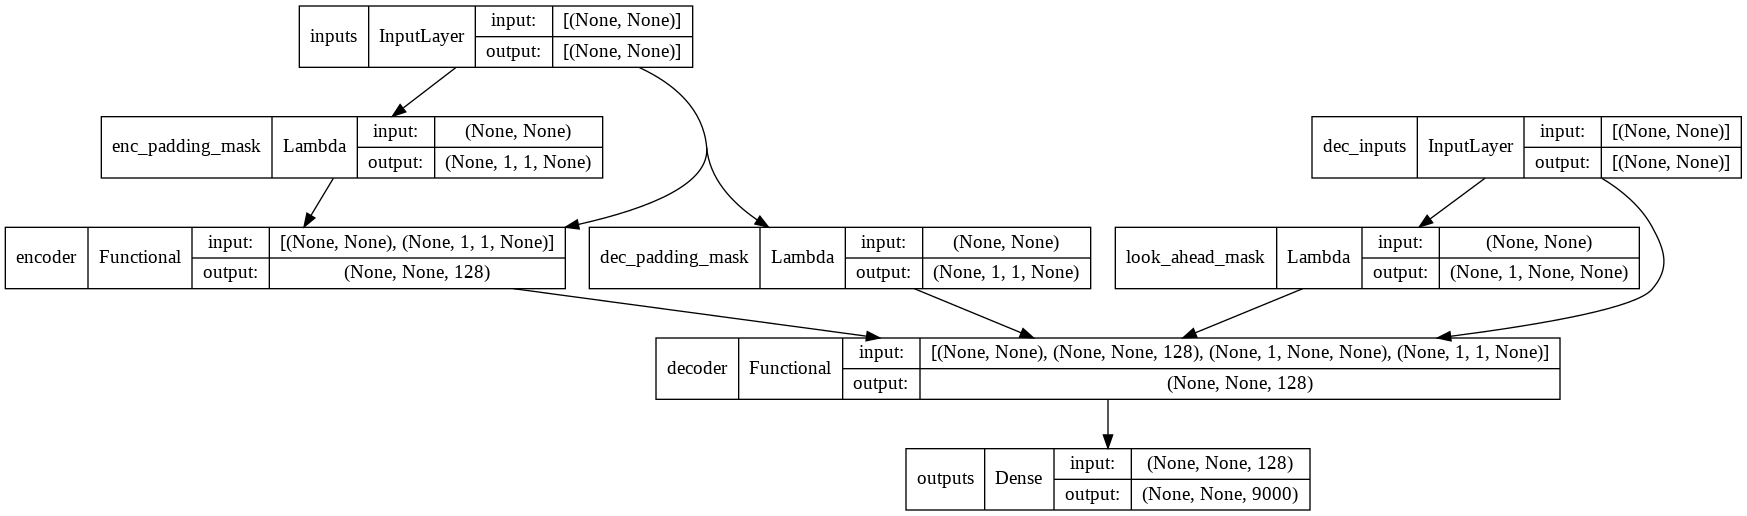

In [80]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(small_transformer, to_file='small_transformer.png', show_shapes=True)

### 19. 손실 함수 정의하기
* 다중 크래스 분류 문제를 풀 예정이므로 크로스 엔트로피 함수를 손실 함수로 정의

### 20. 학습률
* 트랜스포머의 경우 학습률(learning rate)은 고정된 값을 유지하는 것이 아니라, 학습 경과에 따라 변화도록 설계

In [85]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [86]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

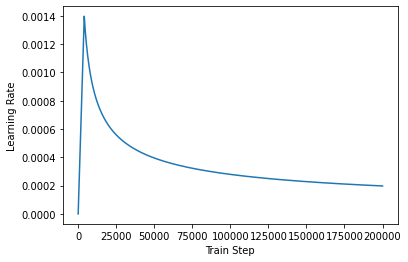

In [87]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 2) Transformer Chatbot Tutorial
### 1. Load Data

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf

In [93]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [94]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11823


In [95]:
print(train_data.isnull().sum())

# Null값은 별도로 존재하지 않음
# 토큰화를 위해서 형태소 분석기 ㄴㄴ, 다른 방법인 학습 기반의 토크나이저 사용할 예정

Q        0
A        0
label    0
dtype: int64


In [96]:
questions = []
for sentence in train_data['Q']:
  # 구두점에 대해서 띄어쓰기
  # ex) 12시 땡! -> 12시 땡 !
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  questions.append(sentence)

In [97]:
answers = []
for sentence in train_data['A']:
  # 구두점에 대해서 띄어쓰기
  # ex) 12시 땡! -> 12시 땡 !
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  answers.append(sentence)

* 질문과 대답에 대해서 상위 5개만 출력하여 구두점들이 띄어쓰기를 통해 분리되었는지 확인해보기

In [98]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


### 2. 단어 집합 생성
* 14챕터 서브워드 토크나이저 챕터에서 배웠던 **서브워드 텍스트 인코더**를 사용해보기
  * 자주 사용되는 서브워드 단위로 토큰을 분리하는 토크나이저로 학습 데이터로부터 학습하여 서브워드로 구성된 단어 집합 생성

In [99]:
# 서브워드 텍스트 인코더를 사용하여 질문, 답변 데이터로부터 단어 집합 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size = 2 ** 13)

* 단어 집합이 생성되었음. 그런데 seq2seq 챕터에서 배웠던 것처럼 인코더-디코더 모델 계열에서는 디코더의 입력으로 사용할 시작을 의미하는 시작 토큰 SOS와 종료 토큰 EOS 또한 존재함
* 해당 토큰들도 단어 집합에 포함시킬 필요가 있으므로 이 두 토큰에 정수를 부여

In [100]:
# 시작 토큰과 종료 토큰에 대한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 +2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [101]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


### 3. 정수 인코딩과 패딩
* 단어 집합을 생성한 후에는 서브워드텍스트인코더와 토크나이저로 정수 인코딩을 진행 가능
  * 이는 토크나이저의 .encode()를 사용하여 가능

In [102]:
# 텍스트 시퀀슬르 정수 시퀀스로 변환
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

임의의 질문 샘플을 정수 인코딩 : [5766, 611, 3509, 141, 685, 3747, 849]


In [103]:
# 20번 질문 샘플로 정수 인코딩 뒤 다시 디코딩
# 서브워드 텍스트 인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode(): 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode(): 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장: 가스비 비싼데 감기 걸리겠어


In [104]:
# 각 정수가 어떤 서브워드로 맵핑되는지 출력
# 서브워드 텍스트 인코더는 의미있는 단위의 서브워드로 토크나이징함
# 띄어쓰기 단위 아니고 형태소 분석 단위 아님
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


In [105]:
# 샘플 1개를 가지고 정수 인코딩과 디코딩 수행
# 이번에는 전체 데이터에 대해서 정수 인코딩과 패딩 진행
# 이를 위한 함수 tokenize_and_filter()를 만듦. 임의로 패딩의 길이는 40

MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [106]:
questions, answers = tokenize_and_filter(questions, answers)

In [107]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [108]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### 4. 인코더와 디코더의 입력, 그리고 레이블 만들기

In [109]:
# 텐서플로 데이터셋 이용해서 셔플을 수행하되, 배치 코기로 데이터를 묶음
# 이 과정에서 교사 강요(Teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스 구성

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰 제거해야 함
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거됨
    },
    {
        'outputs': answers[:, 1:] # 맨 처음 토큰이 제거됨. 시작 토큰이 제거됨
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [110]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


### 5. 트랜스포머 만들기

In [111]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8180, 256)
(1, 8180, 256)


In [113]:
# 학습률과 옵티마이저를 정의하고 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [115]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS)

Epoch 1/10
185/185 [==============================] - 347s 2s/step - loss: 0.8397 - accuracy: 0.0595
Epoch 2/10
185/185 [==============================] - 346s 2s/step - loss: 0.7768 - accuracy: 0.0647
Epoch 3/10
185/185 [==============================] - 347s 2s/step - loss: 0.7074 - accuracy: 0.0716
Epoch 4/10
185/185 [==============================] - 345s 2s/step - loss: 0.6316 - accuracy: 0.0802
Epoch 5/10
185/185 [==============================] - 347s 2s/step - loss: 0.5514 - accuracy: 0.0892
Epoch 6/10
185/185 [==============================] - 344s 2s/step - loss: 0.4678 - accuracy: 0.0991
Epoch 7/10
185/185 [==============================] - 344s 2s/step - loss: 0.3851 - accuracy: 0.1099
Epoch 8/10
185/185 [==============================] - 344s 2s/step - loss: 0.3065 - accuracy: 0.1208
Epoch 9/10
185/185 [==============================] - 344s 2s/step - loss: 0.2359 - accuracy: 0.1316
Epoch 10/10
185/185 [==============================] - 343s 2s/step - loss: 0.1766 - accura

### 6. 챗봇 평가하기

In [116]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [117]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [118]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [119]:
output = predict("영화 볼래?")

Input: 영화 볼래?
Output: 최신 영화가 좋을 것 같아요 .


In [120]:
output = predict("고민이 있어")

Input: 고민이 있어
Output: 생각을 많이 하면 좀 소개시켜드릴게요 .


In [121]:
output = predict("너무 화가나")

Input: 너무 화가나
Output: 자신을 비난하지 마세요 .


In [122]:
output = predict("카페갈래?")

Input: 카페갈래?
Output: 같이 마셔요 .


In [123]:
output = predict("게임하고싶당")

Input: 게임하고싶당
Output: 저도 싶어요 .


In [124]:
output = predict("게임하자")

Input: 게임하자
Output: 급 다이어트 해봐요 .
